In [178]:
import os, os.path
import sys
import time

In [30]:
import shutil

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [44]:

import torch
from torch.nn import Linear
import torch.nn as nn
from torch_geometric.nn import GCNConv

# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader

from torch.utils.data import random_split




In [4]:

sys.path.append('../../ai.rdee')
import ai_rdee

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [69]:
class TGCN_dataset(torch.utils.data.Dataset):
    def __init__(self):
        for f in self.processed_file_names:
            if not os.path.exists(f):
                self.process()
        self.data = torch.load(self.processed_file_names[0])

    @property
    def raw_file_names(self):
        return ['data/sz_adj.csv', 'data/sz_speed.csv']

    @property
    def processed_file_names(self):
        return ['data_sz_GRU.pt']

    def download(self):
        # Download to `self.raw_dir`.
        print("Please download the data manually!")
        sys.exit(0)
        
    def process(self):
        for f in self.raw_file_names:
            if not os.path.exists(f):
                slef.download()
                break
        print("Processing ... ...")
        # Read data into huge `Data` list.
        fn_adj, fn_spd = self.raw_file_names
        df_spd = pd.read_csv(fn_spd)
        S = df_spd.values  # nTimes x nNodes
        
        data = np.zeros((S.shape[0]-14, 15, S.shape[1]))
        for i in range(data.shape[0]):
            data[i,:,:] = S[i:i+15, :]
        
        torch.save(torch.Tensor(data), self.processed_file_names[0])
        print("Process done.")
        
    def clean(self):
        os.remove('data_sz_GRU.pt')
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx: int):
        return self.data[idx, :, :]

In [72]:
ds.clean()

In [73]:
ds = TGCN_dataset()

Processing ... ...
Process done.


In [177]:
class GRU(nn.Module):
    def __init__(self, input_dim, GRU_dim):
        super().__init__()
        self.GRU_dim = GRU_dim
        self.GRULayer = nn.GRU(input_dim, GRU_dim, batch_first=True)
        self.Regressor = nn.Linear(GRU_dim, 3 * input_dim)
        
    def forward(self, inputs):
        batch_size, seq_len, num_nodes = inputs.shape
        h0 = torch.zeros(batch_size, num_nodes * self.GRU_dim).type_as(
            inputs
        )
#         print(inputs.shape)
        out, h_gru = self.GRULayer(inputs)  # h_gru : (1, batchsize, hidden_dim)
#         print(h_gru.shape)
        x = self.Regressor(h_gru.squeeze(0))
        return x

In [75]:
ratio_valid = 0.3

In [199]:
size_valid = int(ratio_valid * len(ds))
size_train = len(ds) - size_valid
ds_learn, ds_valid = random_split(ds, [size_train, size_valid])

In [200]:
def collate_fn(batch):
#     global b1
#     b1 = batch
    # batch: (batchSize, seq, nFeatures)
    batchTS = torch.stack(batch)
    return batchTS[:, :12, :], batchTS[:, 12:, :].view(batchTS.shape[0], -1)

In [201]:
dlr_train = torch.utils.data.DataLoader(ds_learn, shuffle=True, batch_size=64, collate_fn=collate_fn)

In [202]:
dlr_valid = torch.utils.data.DataLoader(ds_valid, shuffle=True, batch_size=size_valid, collate_fn=collate_fn)

In [143]:
a, b = next(iter(dlr_train))

In [131]:
a.shape

torch.Size([64, 12, 156])

In [132]:
b.shape

torch.Size([64, 468])

In [184]:
net = GRU(156, 256)

In [185]:
net.to(device)

GRU(
  (GRULayer): GRU(156, 256, batch_first=True)
  (Regressor): Linear(in_features=256, out_features=468, bias=True)
)

In [186]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [187]:
net.train()

GRU(
  (GRULayer): GRU(156, 256, batch_first=True)
  (Regressor): Linear(in_features=256, out_features=468, bias=True)
)

In [188]:
losses = []
lossesE = []
for epoch in range(1000):
    lossesE = []
    for x, y in dlr_train:
        optim.zero_grad()

        y_hat = net(x.to(device))
        loss = criterion(y_hat, y.to(device))
        if np.isnan(loss.item()):
            print("nan loss! Stop")
            break
        loss.backward()
        optim.step()
        lossesE.append(loss.item())
    losses.append(np.array(lossesE).mean())
    if epoch % 10 == 0:
        print(f"epoch={epoch}, loss={losses[-1]}  |  @{time.ctime()}")
        


epoch=0, loss=241.93960478811553  |  @Sun Sep 24 20:22:20 2023
epoch=10, loss=46.381024447354406  |  @Sun Sep 24 20:22:23 2023
epoch=20, loss=34.57499873999393  |  @Sun Sep 24 20:22:26 2023
epoch=30, loss=31.43452228199352  |  @Sun Sep 24 20:22:29 2023
epoch=40, loss=30.323876467618074  |  @Sun Sep 24 20:22:32 2023
epoch=50, loss=29.52326468265418  |  @Sun Sep 24 20:22:35 2023
epoch=60, loss=29.080830429539535  |  @Sun Sep 24 20:22:39 2023
epoch=70, loss=28.72325897216797  |  @Sun Sep 24 20:22:42 2023
epoch=80, loss=28.358384970462684  |  @Sun Sep 24 20:22:45 2023
epoch=90, loss=28.044156276818477  |  @Sun Sep 24 20:22:48 2023
epoch=100, loss=27.891550988862008  |  @Sun Sep 24 20:22:51 2023
epoch=110, loss=27.66254390369762  |  @Sun Sep 24 20:22:54 2023
epoch=120, loss=27.36736858252323  |  @Sun Sep 24 20:22:57 2023
epoch=130, loss=27.18926493326823  |  @Sun Sep 24 20:23:00 2023
epoch=140, loss=27.030378341674805  |  @Sun Sep 24 20:23:03 2023
epoch=150, loss=26.931156331842597  |  @Sun

In [205]:
xV, yV = next(iter(dlr_valid))

In [209]:
2962*0.3

888.6

In [206]:
xV.shape

torch.Size([888, 12, 156])

In [228]:
rgp = ai_rdee.Regression.RegressionPerformance()

In [211]:
net.eval()

GRU(
  (GRULayer): GRU(156, 256, batch_first=True)
  (Regressor): Linear(in_features=256, out_features=468, bias=True)
)

In [212]:
yV_hat = net(xV.to(device))

In [225]:
yV_hat.shape

torch.Size([888, 468])

In [226]:
yV.shape

torch.Size([888, 468])

In [229]:
rgp.valid(yV_hat.detach().cpu().view(-1), yV.reshape(-1))

In [230]:
rgp.valid.show()

target : tg1
size   = 415584.000
r      =      0.918
r2     =      0.842
rmse   =      5.078
nRMSE  =      0.397
MSE    =     25.789


(25.0, 27.0)

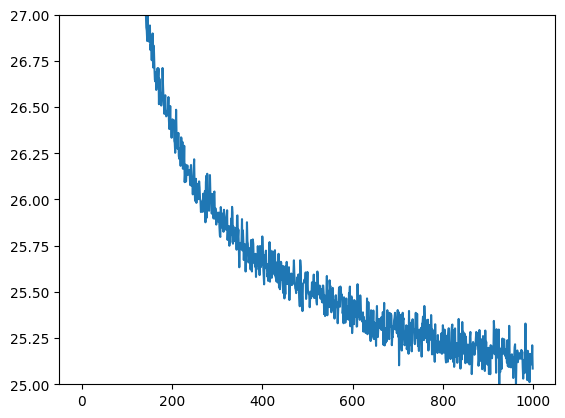

In [237]:
plt.plot(losses)
plt.ylim(25, 27)